In [8]:
import gpytorch
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from gpytorch.kernels import RBFKernel

from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
# !pip install tqdm

In [10]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

In [11]:
def inv_softplus(x):
    return math.log(math.exp(x) - 1)

inv_softplus(1)

0.541324854612918

### Prepare data

In [12]:
true_lengthscale=4.
true_noise=0.2
true_outputscale=1.
N = 500

In [13]:
def generate_dataset(seed=7):
    
    x = np.arange(0., N)
    np.random.seed(seed)
    torch.manual_seed(seed)
    x = torch.from_numpy(x).float()

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.raw_noise.data = torch.tensor([inv_softplus(true_noise**2)])

    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    kernel.base_kernel.raw_lengthscale.data = torch.tensor([inv_softplus(true_lengthscale)])
    kernel.raw_outputscale.data = torch.tensor(inv_softplus(true_outputscale))

    gp = ExactGPModel(
        train_x=None,
        train_y=None,
        likelihood=likelihood,
        kernel=kernel
    )

    gp.eval()
    f_preds = gp(x)
    y_preds = likelihood(f_preds)
    # print(y_preds)
    y = y_preds.rsample().detach()
    # order = np.arange(len(x))
    # np.random.shuffle(order)
    # order = torch.from_numpy(order).long()
    # x, y = x[order], y[order]

    return x, y

Text(0.5, 1.0, 'Data')

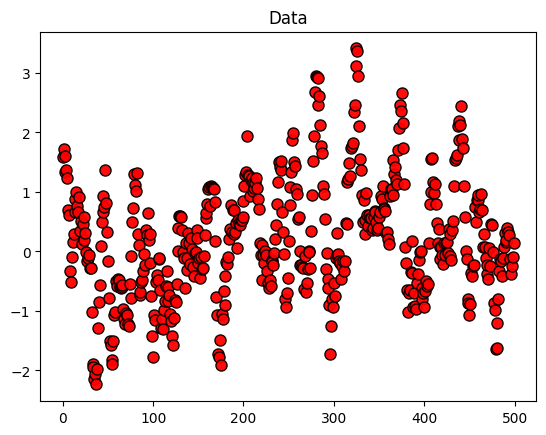

In [14]:
datasets = [generate_dataset(seed=i) for i in range(100)]

x, y = datasets[19]

plt.plot(x, y, "ro", ms=8, alpha=0.95, mec="k")
# plt.plot(x_, f, "--k", alpha=0.95)
plt.title("Data")

## Experiment from the Human Kernel paper

In [15]:
def get_initial_gp(x, y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.raw_noise.data = torch.tensor([inv_softplus(true_noise**2)])

    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    kernel.base_kernel.raw_lengthscale.data = torch.tensor([inv_softplus(true_lengthscale)])
    kernel.raw_outputscale.data = torch.tensor(inv_softplus(true_outputscale))

    gp = ExactGPModel(
        train_x=x,
        train_y=y,
        likelihood=likelihood,
        kernel=kernel
    )
    return gp, likelihood

In [16]:
# def optimize_mll(gp, likelihood, x, y, training_iter=1000, verbose=False, print_frec=100):
#     gp.train()
#     likelihood.train()

# #     optimizer = torch.optim.Adam(gp.parameters(), lr=0.01)
#     optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale], lr=0.01)
#     mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

#     for i in range(training_iter):
#         optimizer.zero_grad()
#         output = gp(x)
#         loss = -mll(output, y)
#         loss.backward()
#         if verbose and (i % print_frec == 0):
#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  noise: %.3f' % (
#                 i + 1, training_iter, loss.item(),
#                 gp.covar_module.base_kernel.lengthscale.item(),
#                 gp.likelihood.noise.item()
#         ))
#         optimizer.step()
#     return gp, likelihood


# # def MLL(gp, x, y):
# def MLL(gp, x, y, w=None):
#     N = len(x)
#     covar_matrix = gp.covar_module(x, x).evaluate()
#     covar_matrix = covar_matrix + gp.likelihood.noise * torch.eye(N).to(x.device)
#     log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
#     log_mll += - 0.5 * torch.logdet(covar_matrix)
#     log_mll += - 0.5 * N * np.log(2 * np.pi)
    
#     if w is not None:
#         log_mll *= w.sum()  # Apply the sum of weights (or a weighted scaling factor)

#     return log_mll

# # def CondtionalMLL(gp, x, y, xm, ym):
#     # return MLL(gp, x, y) - MLL(gp, xm, ym)

# def CondtionalMLL(gp, x, y, xm, ym, wx=None, wy=None):
#     return MLL(gp, x, y, w=wx) - MLL(gp, xm, ym, w=wy)


# # def optimize_cmll(gp, likelihood, x, y, n_cond, training_iter=1000, verbose=False, print_frec=100):
# def optimize_cmll(gp, likelihood, x, y, n_cond, training_iter=1000, verbose=False, print_frec=100, weights=None):
#     x, y = x.clone(), y.clone()
#     gp.train()
#     likelihood.train()
#     if weights is None:
#         weights = torch.ones(len(x))
#     optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale], lr=0.01)
#     # mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

#     for i in range(training_iter):
#         idx = torch.randperm(len(x))[:n_cond]
#         optimizer.zero_grad()
#         wx, wy = weights[:len(x)], weights[idx]  # Separate weights for training and conditional sets
#         loss = -CondtionalMLL(gp, x, y, x[idx], y[idx], wx=wx, wy=wy)
#         # loss = -CondtionalMLL(gp, x, y, x[idx], y[idx])
#         loss.backward()
#         if verbose and (i % print_frec == 0):
#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  noise: %.3f' % (
#                 i + 1, training_iter, loss.item(),
#                 gp.covar_module.base_kernel.lengthscale.item(),
#                 gp.likelihood.noise.item()
#         ))
#         optimizer.step()

#     return gp, likelihood

In [17]:
def optimize_mll(gp, likelihood, x, y, training_iter=100, verbose=False, print_frec=100):
    gp.train()
    likelihood.train()

    optimizer = torch.optim.Adam(gp.parameters(), lr=0.001) #already cmmted 
    # optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale], lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = gp(x)
        loss = -mll(output, y)
        loss.backward()
        if verbose and (i % print_frec == 0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                gp.covar_module.base_kernel.lengthscale.item(),
                gp.likelihood.noise.item()
        ))
        optimizer.step()
    return gp, likelihood


def MLL(gp, x, y):
    N = len(x)
    covar_matrix = gp.covar_module(x, x).evaluate()
    covar_matrix = covar_matrix + gp.likelihood.noise * torch.eye(N).to(x.device)
    log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
    log_mll += - 0.5 * torch.logdet(covar_matrix)
    log_mll += - 0.5 * N * np.log(2 * np.pi)

    return log_mll


def CondtionalMLL(gp, x, y, xm, ym):
    return MLL(gp, x, y) - MLL(gp, xm, ym)


# def optimize_cmll(gp, likelihood, x, y, n_cond, training_iter=1000, verbose=False, print_frec=100):
#     x, y = x.clone(), y.clone()
#     gp.train()
#     likelihood.train()
#     optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale], lr=0.01)
#     mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

#     for i in range(training_iter):
#         idx = torch.randperm(len(x))[:n_cond]
#         optimizer.zero_grad()
#         loss = -CondtionalMLL(gp, x, y, x[idx], y[idx])
#         loss.backward()
#         if verbose and (i % print_frec == 0):
#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  noise: %.3f' % (
#                 i + 1, training_iter, loss.item(),
#                 gp.covar_module.base_kernel.lengthscale.item(),
#                 gp.likelihood.noise.item()
#         ))
#         optimizer.step()
#     return gp, likelihood
def optimize_cmll(gp, likelihood, x, y, n_cond, training_iter=100, verbose=False, print_frec=100):
    x, y = x.clone(), y.clone()  # Clone to avoid modifying original data
    gp.train()
    likelihood.train()
    
    # Include lengthscale and outputscale in the optimizer
    optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale, gp.covar_module.raw_outputscale], lr=0.001)
    
    # Define the marginal log likelihood
    for i in range(training_iter):
        idx = torch.randperm(len(x))[:n_cond]  # Randomly select n_cond points for conditional set
        optimizer.zero_grad()
        
        # Calculate the CMLL loss
        loss = -CondtionalMLL(gp, x, y, x[idx], y[idx])  # Negative because we want to maximize
        
        # Backpropagate and optimize
        loss.backward()
        
        # # Print progress if verbose is enabled
        # if verbose and (i % print_frec == 0):
        #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  outputscale: %.3f  noise: %.3f' % (
        #         i + 1, training_iter, loss.item(),
        #         gp.covar_module.base_kernel.lengthscale.item(),
        #         gp.covar_module.outputscale.item(),
        #         gp.likelihood.noise.item()
        #     ))
        
        # # Update the parameters
        # optimizer.step()
        # print('Current lengthscale:', gp.covar_module.base_kernel.lengthscale.item())
        # print('Current outputscale:', gp.covar_module.outputscale.item())
        # print('Current noise:', gp.likelihood.noise.item())
        # print('Current loss:', loss.item())
    
    return gp, likelihood


In [18]:
# def MLL(gp, x, y):
#     N = len(x)
#     covar_matrix = gp.covar_module(x, x).evaluate()
#     covar_matrix = covar_matrix + gp.likelihood.noise * torch.eye(N).to(x.device)
#     log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
#     log_mll += - 0.5 * torch.logdet(covar_matrix)
#     log_mll += - 0.5 * N * np.log(2 * np.pi)

#     return log_mll


# def CondtionalMLL(gp, x, y, xm, ym):
#     return MLL(gp, x, y) - MLL(gp, xm, ym)


# def optimize_cmll(gp, likelihood, x, y, n_cond, training_iter=1000, verbose=False, print_frec=100):
#     x, y = x.clone(), y.clone()
#     gp.train()
#     likelihood.train()
#     optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale], lr=0.01)
#     mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    
#      for i in range(training_iter):
#         idx = torch.randperm(len(x))[:n_cond]
#         optimizer.zero_grad()
#         loss = -CondtionalMLL(gp, x, y, x[idx], y[idx])
#         loss.backward()
#         if verbose and (i % print_frec == 0):
#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  noise: %.3f' % (
#                 i + 1, training_iter, loss.item(),
#                 gp.covar_module.base_kernel.lengthscale.item(),
#                 gp.likelihood.noise.item()
#         ))
#         optimizer.step()
#     return gp, likelihood

In [19]:
# lengthscales = []
clml_lengthscales = []

for ds in tqdm.tqdm(datasets[3:10]):
#     ds_lengthscales = []
    ds_clml_lengthscales = []
    for n_observed in range(1, N):
        x, y = ds
        x, y = x[:n_observed], y[:n_observed]
        # Optimize LML
#         gp, likelihood = get_initial_gp(x, y)
#         gp, likelihood = optimize_mll(gp, likelihood, x, y, training_iter=1000)
#         lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
#         ds_lengthscales.append(lengthscale)
        
        # Optimize CLML
        # n_cond = n_observed
        n_cond = int(0.9 * n_observed) #cmmted
        gp, likelihood = get_initial_gp(x, y)
        gp, likelihood = optimize_cmll(gp, likelihood, x, y, n_cond=n_cond, training_iter=100)

        lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
        ds_clml_lengthscales.append(lengthscale)

    clml_lengthscales.append(ds_clml_lengthscales)
#     lengthscales.append(ds_lengthscales)
# lengthscales = np.array(lengthscales)
clml_lengthscales = np.array(clml_lengthscales)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_3073239/743582767.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115405/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y
100%|██████████| 7/7 [45:54<00:00, 393.46s/it]


In [20]:
lengthscales = []
# clml_lengthscales = []

for ds in tqdm.tqdm(datasets[3:10]):
    ds_lengthscales = []
    # ds_clml_lengthscales = []
    for n_observed in range(1, N):
        x, y = ds
        x, y = x[:n_observed], y[:n_observed]
        # Optimize LML
        gp, likelihood = get_initial_gp(x, y)
        gp, likelihood = optimize_mll(gp, likelihood, x, y, training_iter=100)
        lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
        ds_lengthscales.append(lengthscale)
        
        # # Optimize CLML
        # n_cond = int(0.9 * n_observed)
        # gp, likelihood = get_initial_gp(x, y)
        # gp, likelihood = optimize_cmll(gp, likelihood, x, y, n_cond=n_cond, training_iter=10)
        # lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
        # ds_clml_lengthscales.append(lengthscale)

    # clml_lengthscales.append(ds_clml_lengthscales)
    lengthscales.append(ds_lengthscales)
lengthscales = np.array(lengthscales)
# clml_lengthscales = np.array(clml_lengthscales)

100%|██████████| 7/7 [21:34<00:00, 184.93s/it]


Text(0.5, 0, 'Number of observations, $n$')

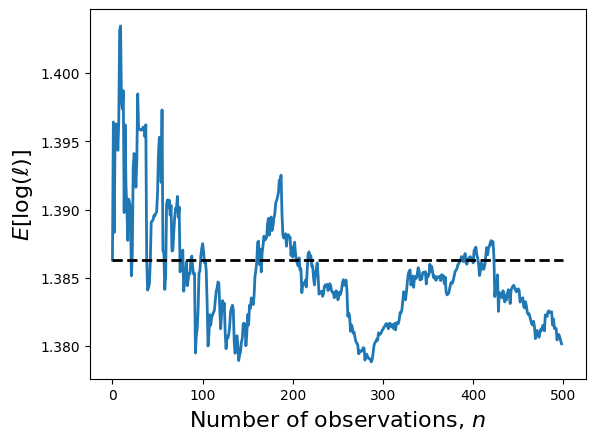

In [21]:
plt.plot(np.mean(np.log(lengthscales), axis=0), lw=2)
plt.plot([0, N], [np.log(4)] * 2, "--k", lw=2)
plt.ylabel(r"$E[\log(\ell)]$", fontsize=16)
plt.xlabel(r"Number of observations, $n$", fontsize=16)

Text(0.5, 0, 'Number of observations, $n$')

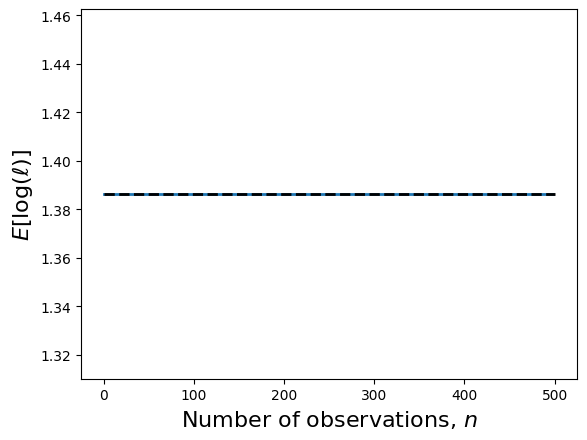

In [22]:
#CLML
plt.plot(np.mean(np.log(clml_lengthscales), axis=0), lw=2)
plt.plot([0, N], [np.log(4)] * 2, "--k", lw=2)
plt.ylabel(r"$E[\log(\ell)]$", fontsize=16)
plt.xlabel(r"Number of observations, $n$", fontsize=16)

In [23]:
# lengthscales = []
# # clml_lengthscales = []

# for ds in tqdm.tqdm(datasets[3:10]):
#     ds_lengthscales = []
#     # ds_clml_lengthscales = []
#     for n_observed in range(1, 150):
#         x, y = ds
#         x, y = x[:n_observed], y[:n_observed]
#         # Optimize LML
#         gp, likelihood = get_initial_gp(x, y)
#         gp, likelihood = optimize_mll(gp, likelihood, x, y, training_iter=1000)
#         lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
#         ds_lengthscales.append(lengthscale)
        
#         # Optimize CLML
#         # n_cond = int(0.9 * n_observed)
#         # gp, likelihood = get_initial_gp(x, y)
#         # gp, likelihood = optimize_cmll(gp, likelihood, x, y, n_cond=n_cond, training_iter=1000)
#         # lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
#         # ds_clml_lengthscales.append(lengthscale)

#     # clml_lengthscales.append(ds_clml_lengthscales)
#     lengthscales.append(ds_lengthscales)
# lengthscales = np.array(lengthscales)
# # clml_lengthscales = np.array(clml_lengthscales)

In [24]:
import os

# Create the 'plots' directory if it doesn't exist
os.makedirs("plots", exist_ok=True)
np.savez("plots/human_kernel_results",
        lengthscales=lengthscales)

In [25]:
lengthscales = np.load("plots/human_kernel_results.npz")["lengthscales"]

In [26]:
import os

# Create the 'plots' directory if it doesn't exist
os.makedirs("plots", exist_ok=True)
np.savez("plots/human_kernel_results_clml",
        clml_lengthscales=clml_lengthscales)

In [27]:
clml_lengthscales = np.load("plots/human_kernel_results_clml.npz")["clml_lengthscales"]

In [28]:
np.argmax(lengthscales[:, -1])

3

In [29]:
np.argmax(clml_lengthscales[:, -1])

0

## True GP fit

In [30]:
n_observed = 149
data_i = 12

(-1.0, 150.0)

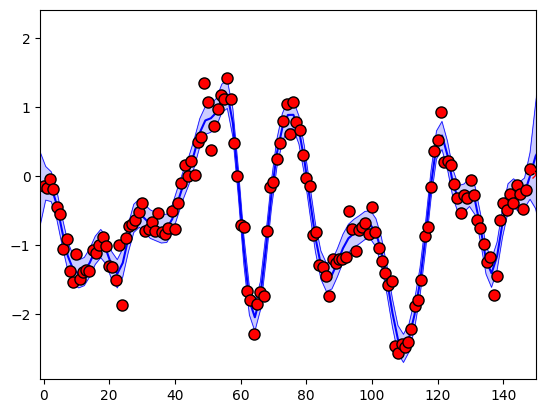

In [31]:
x_test = torch.linspace(-1, N, 300)

x, y = datasets[data_i]

gp, likelihood = get_initial_gp(x[:n_observed], y[:n_observed])

gp.eval()
likelihood.eval()

f_preds = gp(x_test)
pred_means = f_preds.mean.detach().numpy()
pred_std = f_preds.stddev.detach().numpy()

plt.plot(x_test.detach().numpy(), pred_means, "-b")
plt.plot(x_test.detach().numpy(), pred_means + 2 * pred_std, "-b", lw=.5)
plt.plot(x_test.detach().numpy(), pred_means - 2 * pred_std, "-b", lw=.5)
plt.fill_between(x_test.detach().numpy(), 
                 pred_means + 2 * pred_std,
                 pred_means - 2 * pred_std,
                 color="b", alpha=0.2)

plt.plot(x[:n_observed].detach().numpy(), y[:n_observed].detach().numpy(), "ro", ms=8, mec="k")
plt.plot(x[n_observed:].detach().numpy(), y[n_observed:].detach().numpy(), "rx")
plt.xlim(-1, n_observed+1)

## Optimization

In [32]:
# x, y = datasets[3]
gp, likelihood = get_initial_gp(x[:n_observed], y[:n_observed])
gp, likelihood = optimize_mll(gp, likelihood, x[:n_observed], y[:n_observed], training_iter=1000, verbose=True)

Iter 1/1000 - Loss: 0.304   lengthscale: 4.000  noise: 0.040
Iter 101/1000 - Loss: 0.294   lengthscale: 4.095  noise: 0.041


Iter 201/1000 - Loss: 0.286   lengthscale: 4.178  noise: 0.041
Iter 301/1000 - Loss: 0.280   lengthscale: 4.250  noise: 0.042
Iter 401/1000 - Loss: 0.276   lengthscale: 4.307  noise: 0.042
Iter 501/1000 - Loss: 0.274   lengthscale: 4.351  noise: 0.042
Iter 601/1000 - Loss: 0.273   lengthscale: 4.381  noise: 0.042
Iter 701/1000 - Loss: 0.272   lengthscale: 4.401  noise: 0.042
Iter 801/1000 - Loss: 0.272   lengthscale: 4.413  noise: 0.042
Iter 901/1000 - Loss: 0.271   lengthscale: 4.420  noise: 0.042


Text(0.5, 1.0, 'MLL')

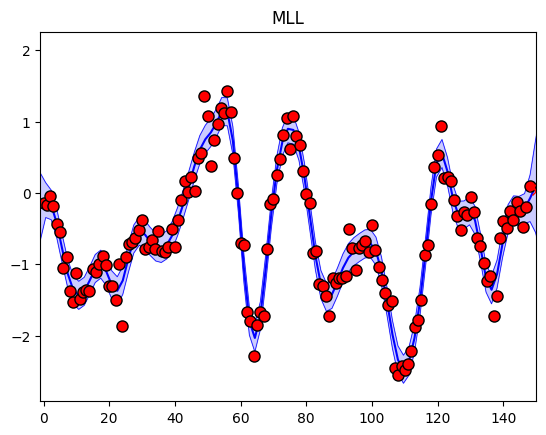

In [33]:
gp.eval()
likelihood.eval()

f_preds = gp(x_test)
pred_means = f_preds.mean.detach().numpy()
pred_std = f_preds.stddev.detach().numpy()

plt.plot(x_test.detach().numpy(), pred_means, "-b")
plt.plot(x_test.detach().numpy(), pred_means + 2 * pred_std, "-b", lw=.5)
plt.plot(x_test.detach().numpy(), pred_means - 2 * pred_std, "-b", lw=.5)
plt.fill_between(x_test.detach().numpy(), 
                 pred_means + 2 * pred_std,
                 pred_means - 2 * pred_std,
                 color="b", alpha=0.2)

plt.plot(x[:n_observed].detach().numpy(), y[:n_observed].detach().numpy(), "ro", ms=8, mec="k")
plt.plot(x[n_observed:].detach().numpy(), y[n_observed:].detach().numpy(), "rx")
plt.xlim(-1, n_observed+1)
plt.title("MLL")

## CMLL Optimization

In [34]:
# x, y = datasets[3]
gp, likelihood = get_initial_gp(x[:n_observed], y[:n_observed])
gp, likelihood = optimize_cmll(gp, likelihood, x[:n_observed], y[:n_observed], n_cond=120, 
                               training_iter=1000, verbose=True)

(-1.0, 150.0)

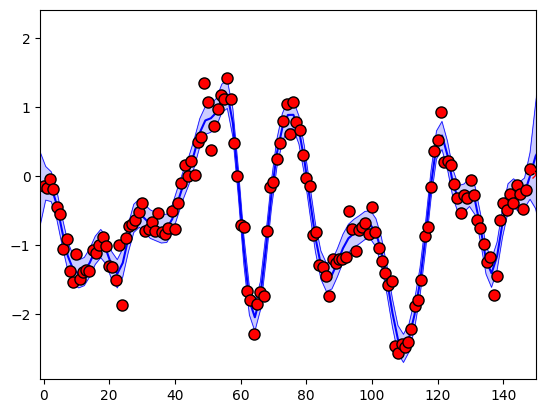

In [35]:
gp.eval()
likelihood.eval()

f_preds = gp(x_test)
pred_means = f_preds.mean.detach().numpy()
pred_std = f_preds.stddev.detach().numpy()

plt.plot(x_test.detach().numpy(), pred_means, "-b")
plt.plot(x_test.detach().numpy(), pred_means + 2 * pred_std, "-b", lw=.5)
plt.plot(x_test.detach().numpy(), pred_means - 2 * pred_std, "-b", lw=.5)
plt.fill_between(x_test.detach().numpy(), 
                 pred_means + 2 * pred_std,
                 pred_means - 2 * pred_std,
                 color="b", alpha=0.2)

plt.plot(x[:n_observed].detach().numpy(), y[:n_observed].detach().numpy(), "ro", ms=8, mec="k")
plt.plot(x[n_observed:].detach().numpy(), y[n_observed:].detach().numpy(), "rx")
plt.xlim(-1, n_observed+1)
